In [1]:
# Import some libraries

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision.utils import save_image

In [2]:
import os

In [3]:
newpath = './images' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [4]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [5]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [6]:
# Define data loading step

batch_size = 128

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
dataset = FashionMNIST('./data', train=True, transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

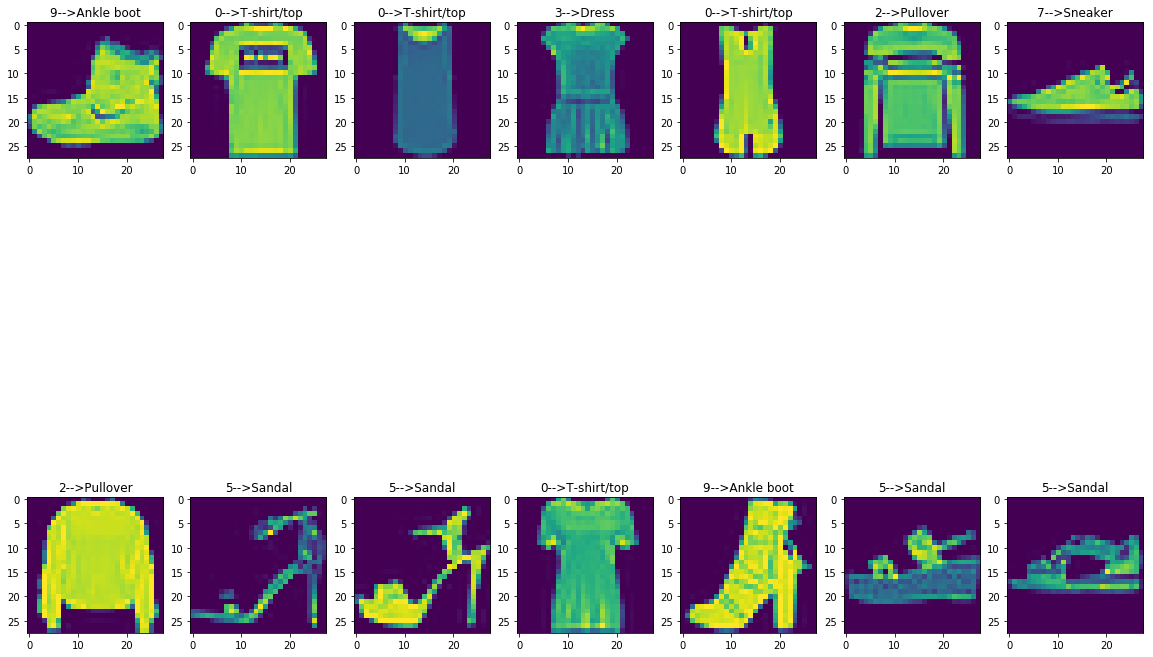

In [8]:
# show some images
plt.figure(figsize=(20,16))
dictio = {'0':'T-shirt/top', '1':'Trouser', '2':'Pullover', '3':'Dress', '4':'Coat', '5':'Sandal', '6':'Shirt', '7':'Sneaker', '8':'Bag', '9':'Ankle boot'}
for i in range(14):
    plt.subplot(2, 7, i + 1)
    image, label = dataloader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.title('{}-->{}' .format(label,dictio[str(label.item())]))
plt.show()

In [9]:
# Set up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on {}'.format(device))

Training on cpu


In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=3,padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=1, padding=0),
        )
        
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=5,stride=3,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=8,out_channels=1,kernel_size=2,stride=2,padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()

## 2.1 Model parameters checking

In [12]:
for parameter in model.parameters():
    print(parameter.shape)

torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([8, 16, 3, 3])
torch.Size([8])
torch.Size([8, 16, 3, 3])
torch.Size([16])
torch.Size([16, 8, 5, 5])
torch.Size([8])
torch.Size([8, 1, 2, 2])
torch.Size([1])


In [13]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
         LeakyReLU-2           [-1, 16, 10, 10]               0
         AvgPool2d-3             [-1, 16, 5, 5]               0
            Conv2d-4              [-1, 8, 3, 3]           1,160
         LeakyReLU-5              [-1, 8, 3, 3]               0
         AvgPool2d-6              [-1, 8, 2, 2]               0
   ConvTranspose2d-7             [-1, 16, 5, 5]           1,168
         LeakyReLU-8             [-1, 16, 5, 5]               0
   ConvTranspose2d-9            [-1, 8, 15, 15]           3,208
        LeakyReLU-10            [-1, 8, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              33
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 5,729
Trainable params: 5,729
Non-trainable params: 0
-----------------------------------

In [14]:
# Configure the optimiser

learning_rate = 1e-3
L2_regularization = 1e-5

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=L2_regularization,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20] , loss:{0.1654}
epoch [2/20] , loss:{0.1272}
epoch [3/20] , loss:{0.1263}
epoch [4/20] , loss:{0.1163}
epoch [5/20] , loss:{0.1091}
epoch [6/20] , loss:{0.1217}
epoch [7/20] , loss:{0.1049}
epoch [8/20] , loss:{0.1006}
epoch [9/20] , loss:{0.0979}
epoch [10/20] , loss:{0.0989}
epoch [11/20] , loss:{0.0982}
epoch [12/20] , loss:{0.1007}
epoch [13/20] , loss:{0.0962}
epoch [14/20] , loss:{0.0876}
epoch [15/20] , loss:{0.0883}
epoch [16/20] , loss:{0.0943}
epoch [17/20] , loss:{0.0815}
epoch [18/20] , loss:{0.0847}
epoch [19/20] , loss:{0.0794}
epoch [20/20] , loss:{0.0877}


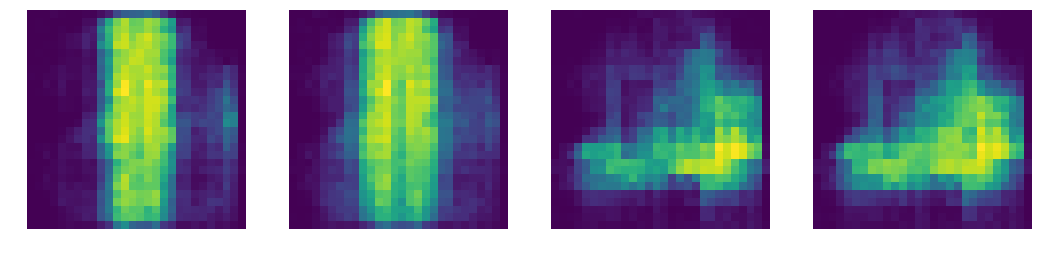

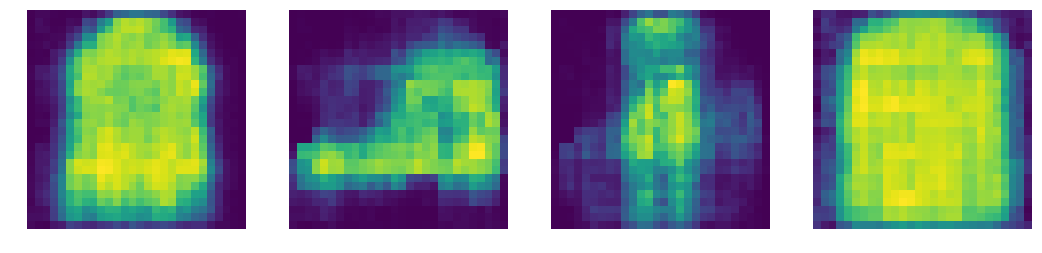

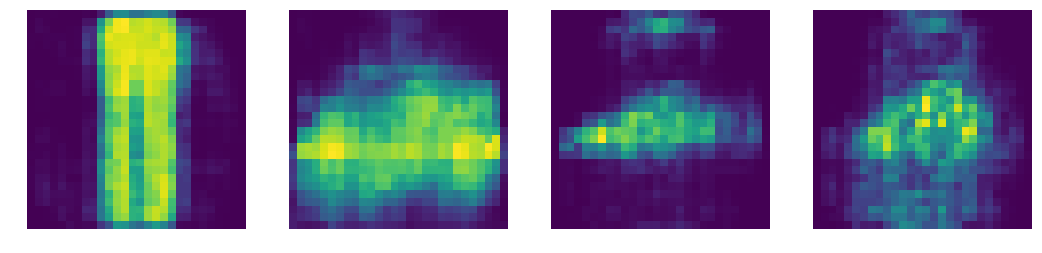

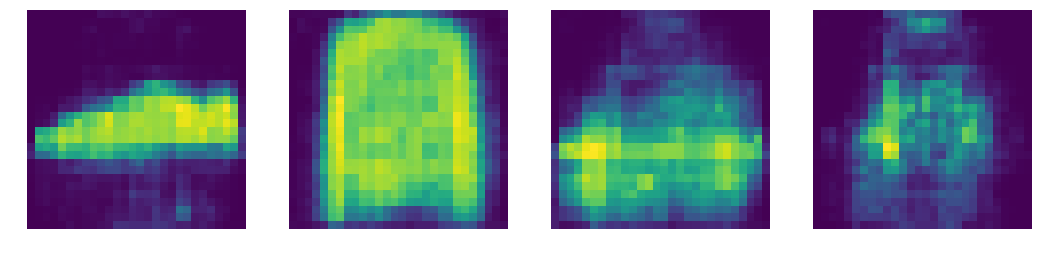

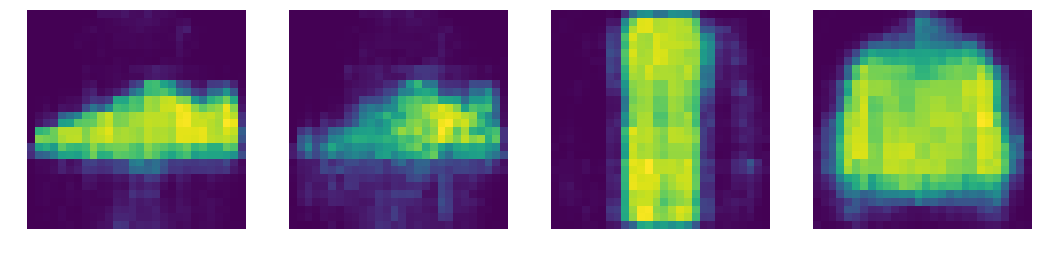

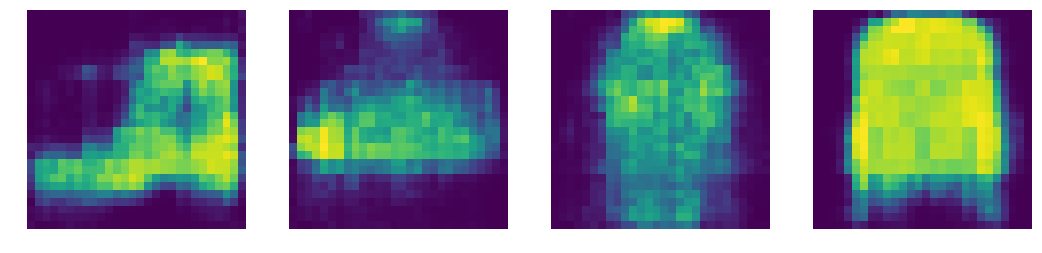

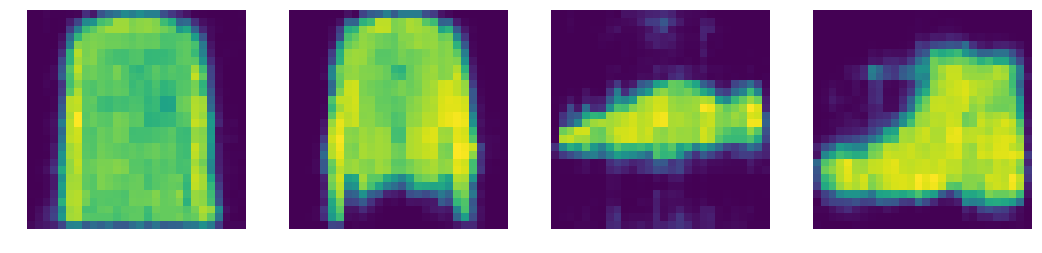

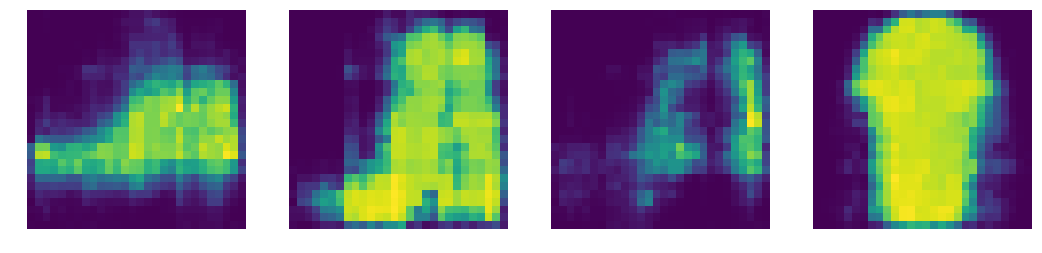

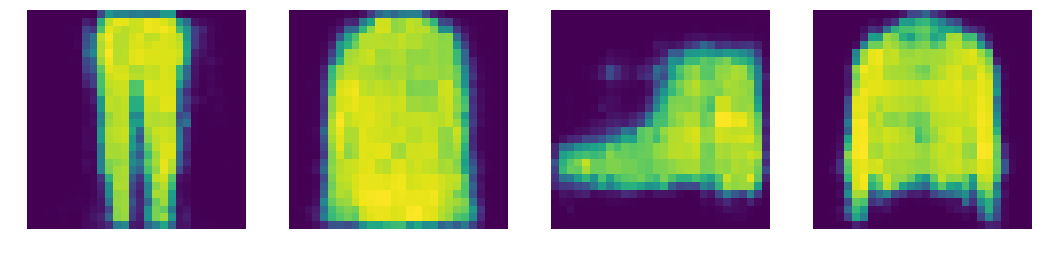

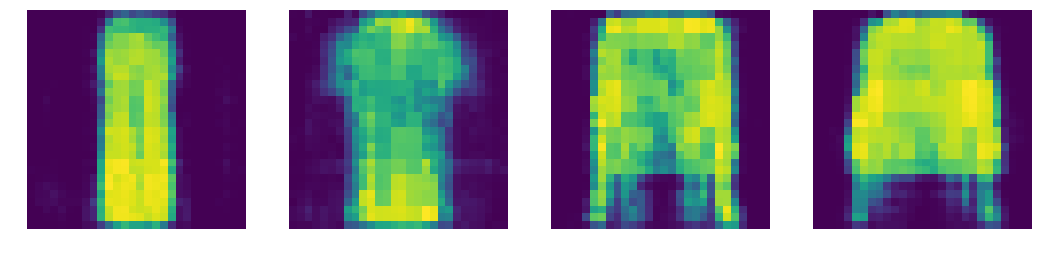

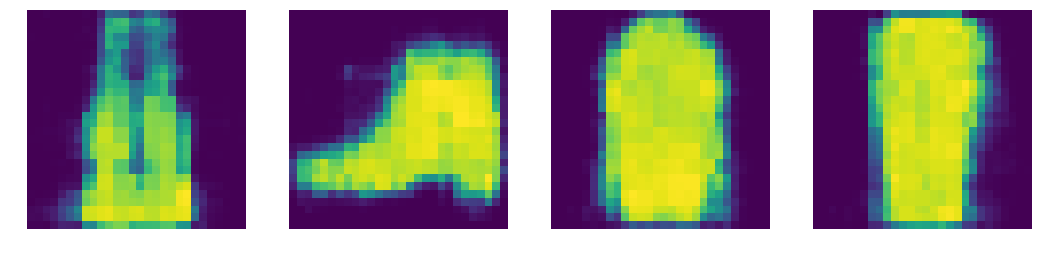

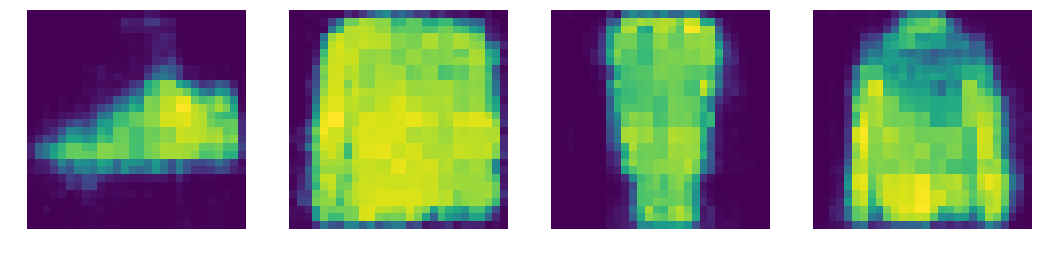

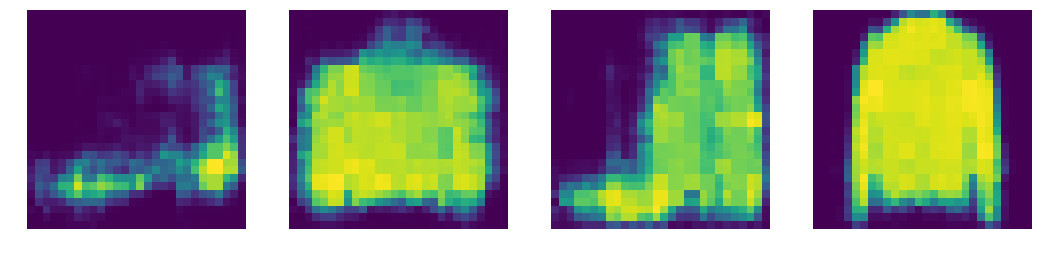

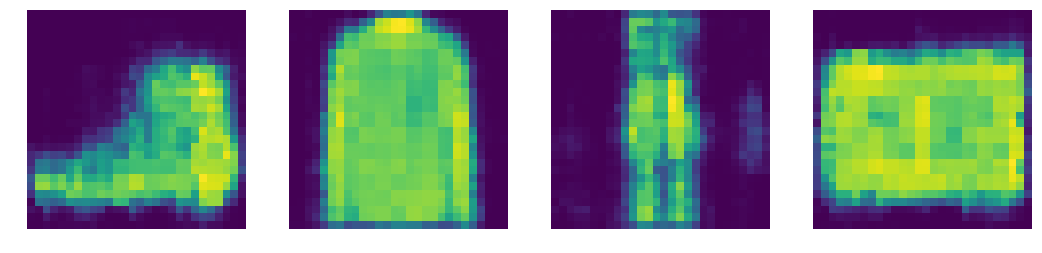

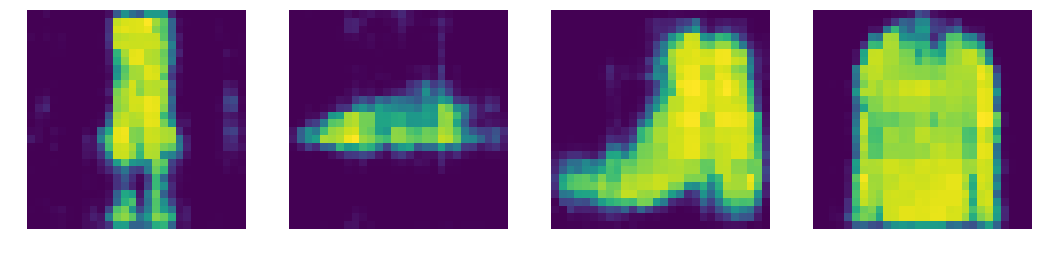

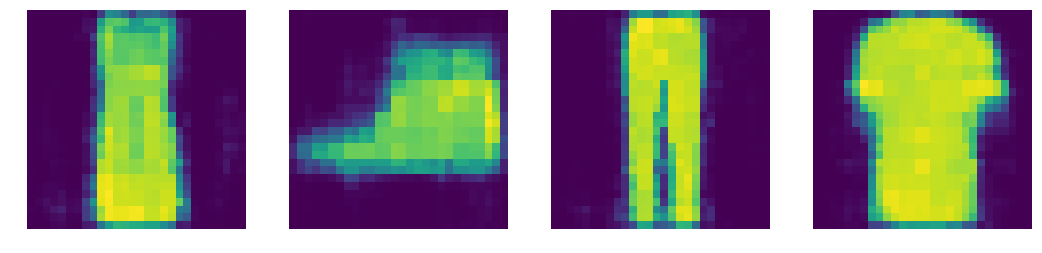

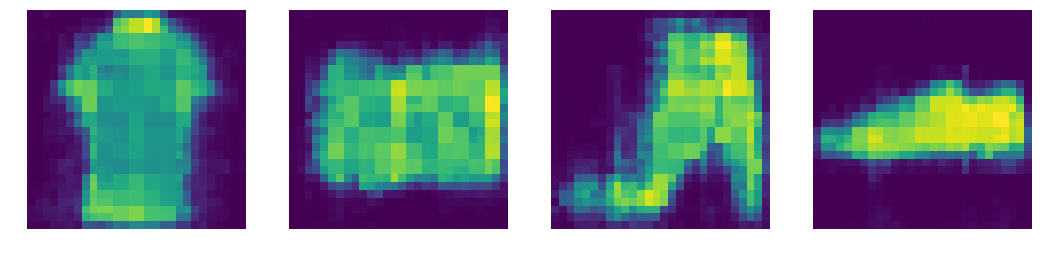

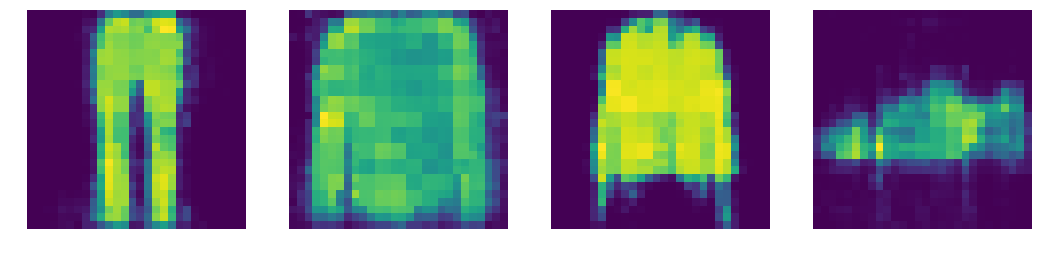

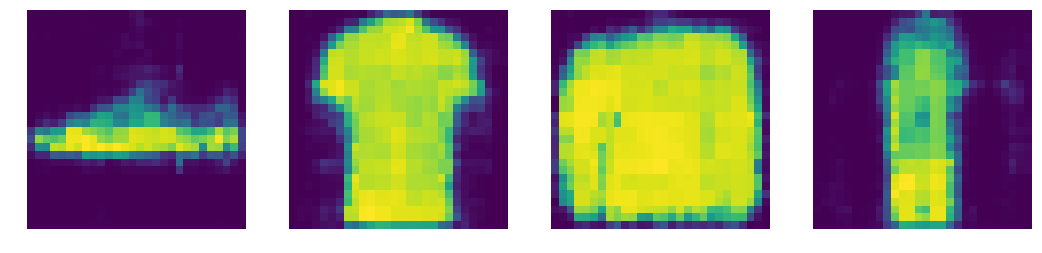

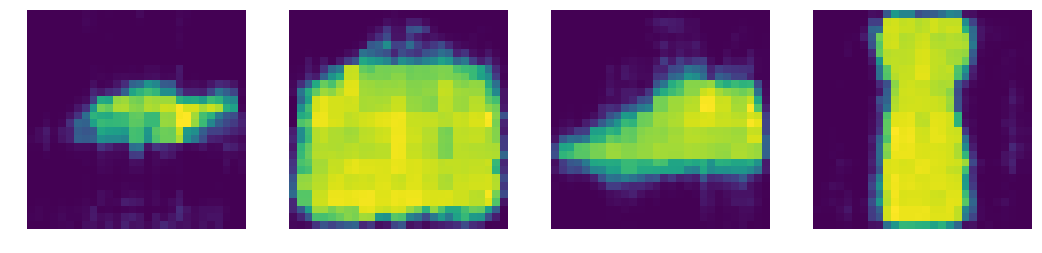

In [15]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img.requires_grad_()
        img = img.view(-1, 1, 28, 28)

#         img_bad = do(img).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [%d/%d] , loss:{%.4f}' % (epoch + 1,num_epochs, loss.item()))
    save_image(output, "./images/{}.png".format(epoch+1))

    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE
plt.show()